<a href="https://colab.research.google.com/github/smishr97/Mechanism-of-Action-MoA---DeepNN/blob/main/Mechanism_of_Action_(MoA)_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c lish-moa
! kaggle config set -n iterativestratification
! unzip sample_submission.csv.zip
! unzip train_features.csv.zip
! unzip train_targets_nonscored.csv.zip
! unzip train_drug.csv
! unzip train_targets_scored.csv.zip
! unzip test_features.csv.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 55% 5.00M/9.16M [00:00<00:00, 5.67MB/s]
100% 9.16M/9.16M [00:00<00:00, 9.94MB/s]
  0% 0.00/257k [00:00<?, ?B/s]
100% 257k/257k [00:00<00:00, 82.7MB/s]
  0% 0.00/38.9k [00:00<?, ?B/s]
100% 38.9k/38.9k [00:00<00:00, 39.1MB/s]
 75% 41.0M/54.8M [00:02<00:00, 17.1MB/s]
100% 54.8M/54.8M [00:02<00:00, 26.5MB/s]
  0% 0.00/233k [00:00<?, ?B/s]
100% 233k/233k [00:00<00:00, 74.6MB/s]
  0% 0.00/535k [00:00<?, ?B/s]
100% 535k/535k [00:00<00:00, 96.4MB/s]
usage: kaggle config set [-h] -n NAME -v VALUE
kaggle config set: error: argument -v/--value is required
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  train_features.csv.zip
  inflating: train_features.csv      
Archive:  train_targets_nonscored.csv.zip
  inflating: train_targets_nonscored.csv  
Archive:  train_drug.csv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part arch

In [8]:
import os
import copy
import tqdm
import pickle
import random
import warnings
warnings.filterwarnings("ignore")
os.environ["CUDA_LAUNCH_BLOCKING"] = '1'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from pickle import load,dump

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans

import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import DataLoader, Dataset
! pip install pytorch_tabnet
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

In [11]:
train_features = pd.read_csv('/content/train_features.csv')
test_features = pd.read_csv('/content/test_features.csv')
train_targets_scored = pd.read_csv('/content/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('/content/train_targets_nonscored.csv')
train_drug = pd.read_csv('/content/train_drug.csv')

In [12]:
train_features2=train_features.copy()
test_features2=test_features.copy()

In [13]:
print('Training Features Samples')
display(train_features.head(3))
print('Training Features Description')
display(train_features.describe())

Training Features Samples


sig_id cp_type  cp_time cp_dose  ...    c-96    c-97    c-98    c-99
0  id_000644bb2  trt_cp       24      D1  ... -0.3981  0.2139  0.3801  0.4176
1  id_000779bfc  trt_cp       72      D1  ...  0.1522  0.1241  0.6077  0.7371
2  id_000a6266a  trt_cp       48      D1  ... -0.6417 -0.2187 -1.4080  0.6931

[3 rows x 876 columns]

Training Features Description


cp_time           g-0  ...          c-98          c-99
count  23814.000000  23814.000000  ...  23814.000000  23814.000000
mean      48.020156      0.248366  ...     -0.470252     -0.301505
std       19.402807      1.393399  ...      1.834828      1.407918
min       24.000000     -5.513000  ...    -10.000000    -10.000000
25%       24.000000     -0.473075  ...     -0.592600     -0.562900
50%       48.000000     -0.008850  ...      0.014000     -0.019500
75%       72.000000      0.525700  ...      0.461275      0.438650
max       72.000000     10.000000  ...      3.111000      3.805000

[8 rows x 873 columns]

In [14]:
print('Training Features Samples')
display(test_features.head(3))
print('Training Features Description')
display(test_features.describe())

Training Features Samples


sig_id      cp_type  cp_time cp_dose  ...    c-96    c-97    c-98    c-99
0  id_0004d9e33       trt_cp       24      D1  ...  0.0210 -0.0502  0.1510 -0.7750
1  id_001897cda       trt_cp       72      D1  ...  0.0359 -0.4764 -1.3810 -0.7300
2  id_002429b5b  ctl_vehicle       24      D1  ...  0.8662  1.0160  0.4924 -0.1942

[3 rows x 876 columns]

Training Features Description


cp_time          g-0  ...         c-98         c-99
count  3982.000000  3982.000000  ...  3982.000000  3982.000000
mean     48.030136     0.197471  ...    -0.404859    -0.269792
std      19.414155     1.373476  ...     1.790883     1.355936
min      24.000000    -5.321000  ...   -10.000000   -10.000000
25%      24.000000    -0.502725  ...    -0.531075    -0.541950
50%      48.000000    -0.060700  ...     0.030750    -0.006250
75%      72.000000     0.454650  ...     0.487000     0.422800
max      72.000000    10.000000  ...     3.859000     4.149000

[8 rows x 873 columns]

In [15]:
train_missing = train_features.isnull().sum().sum()
test_missing = test_features.isnull().sum().sum()
if train_missing & test_missing == 0:
    print("Train and Test Files have no missing values")
else: print("Train and Test Files have missing values")  

Train and Test Files have no missing values


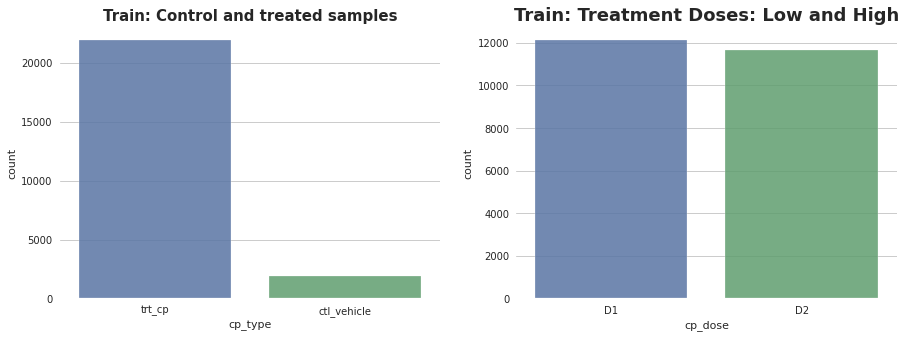

In [16]:
plt.style.use('seaborn')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
#1 rows 2 cols
#first row, first col
ax1 = plt.subplot2grid((1,2),(0,0))
sns.countplot(x='cp_type', data=train_features, alpha=0.85)
plt.title('Train: Control and treated samples', fontsize=15, weight='bold')
#first row sec col
ax1 = plt.subplot2grid((1,2),(0,1))
sns.countplot(x='cp_dose', data=train_features, alpha=0.85)
plt.title('Train: Treatment Doses: Low and High',weight='bold', fontsize=18)
plt.show()

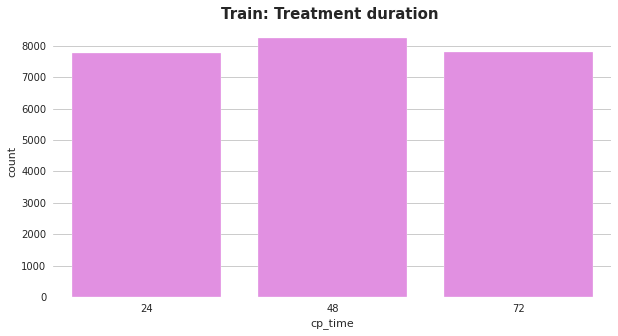

In [17]:
plt.figure(figsize=(10,5))
sns.countplot( train_features['cp_time'], color='violet')
plt.title("Train: Treatment duration ", fontsize=15, weight='bold')
plt.show()

In [18]:
GENES = [g for g in train_features.columns if g.startswith("g-")]
print(f"Number of gene features: {len(GENES)}")
CELLS = [c for c in train_features.columns if c.startswith("c-")]
print(f"Number of cell features: {len(CELLS)}")

Number of gene features: 772
Number of cell features: 100


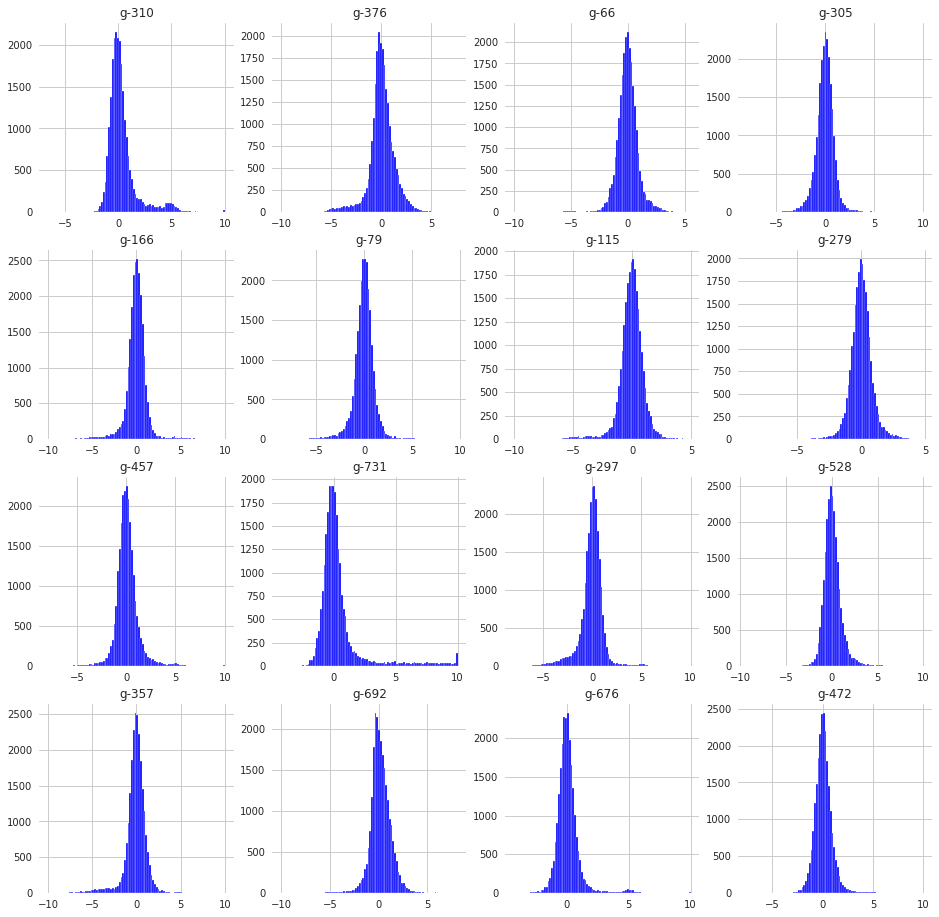

In [19]:
plt.figure(figsize=(16,16))
sns.set_style('whitegrid')
gene_choice=np.random.choice(len(GENES),16)
for i,col in enumerate(gene_choice):
    plt.subplot(4,4,i+1)
    plt.hist(train_features.loc[:,GENES[col]],bins=100,color="blue")
    plt.title(GENES[col])

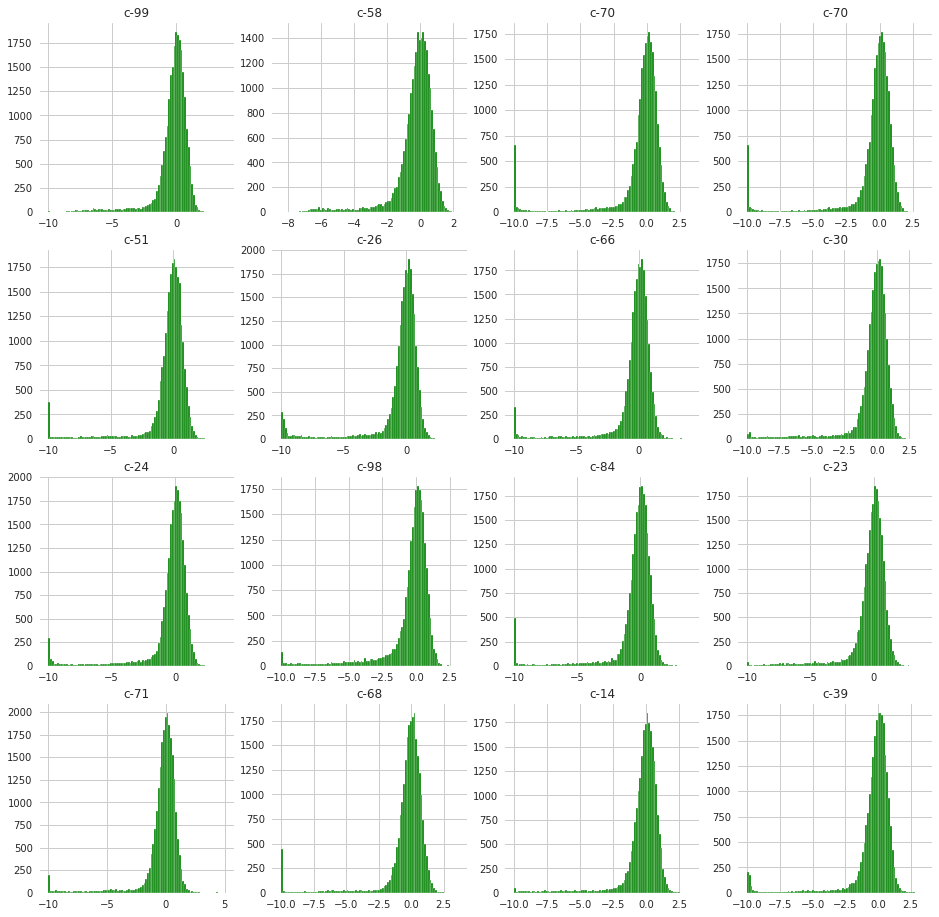

In [20]:
plt.figure(figsize=(16,16))
sns.set_style('whitegrid')
cell_choice=np.random.choice(len(CELLS),16)
for i,col in enumerate(cell_choice):
    plt.subplot(4,4,i+1)
    plt.hist(train_features.loc[:,CELLS[col]],bins=100,color="green")
    plt.title(CELLS[col])

In [21]:
def treated(a):
    treated= a[a['cp_type']=='trt_cp']
    return treated

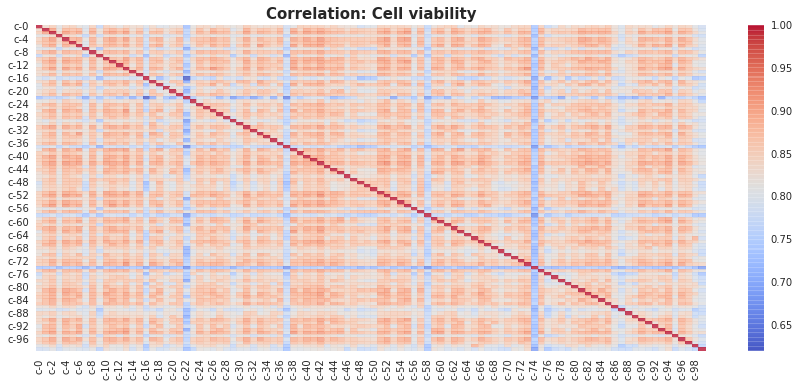

In [22]:
cells = treated(train_features)[CELLS]
plt.figure(figsize=(15,6))
sns.heatmap(cells.corr(),cmap='coolwarm',alpha=0.75)
plt.title('Correlation: Cell viability', fontsize=15, weight='bold')
plt.show()

In [23]:
def corrs(data,col1="Cell 1",col2="Cell 2",rows=5,thresh=0.9,pos=[1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53]):
    #Correlation between genes
    corre=data.corr()
    #Unstack the dataframe
    s=corre.unstack()
    so=s.sort_values(kind='quicksort',ascending=False)
    #Create new dataframe
    so2=pd.DataFrame(so).reset_index()
    so2=so2.rename(columns={0:'correlation','level_0':col1,'level_1':col2})
    #Filter out the coef 1 correlation between the same drugs
    so2=so2[so2['correlation']!=1]
    #Drop pair duplicates
    so2=so2.reset_index()
    pos=pos
    so3=so2.drop(so2.index[pos])
    so3=so3.drop('index',axis=1)
    #Show the first 10 high correlations
    cm = sns.light_palette("pink", as_cmap=True)
    s = so3.head(rows).style.background_gradient(cmap=cm)
    print(f"{len(so2[so2['correlation']>thresh])/2} {col1} pairs have +{thresh} correlation.")
    return s

In [24]:
corrs(cells,'cell 1','cell 2',rows=8)

173.0 cell 1 pairs have +0.9 correlation.


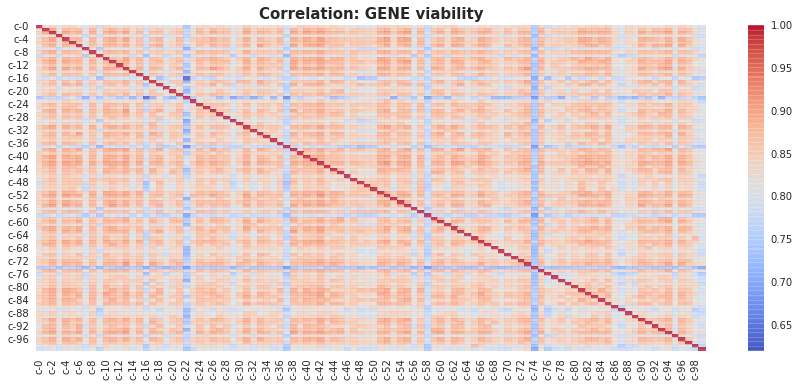

In [25]:
genes = treated(train_features)[GENES]
plt.figure(figsize=(15,6))
sns.heatmap(cells.corr(),cmap='coolwarm',alpha=0.75)
plt.title('Correlation: GENE viability', fontsize=15, weight='bold')
plt.show()

In [26]:
corrs(genes,'Gene 1', 'Gene 2',rows=8)

1.0 Gene 1 pairs have +0.9 correlation.


In [27]:
target_cols_scored=[col for col in train_targets_scored.columns if col not in ['sig_id']]
target_cols_nonscored=[col for col in train_targets_nonscored.columns if col not in ['sig_id']]

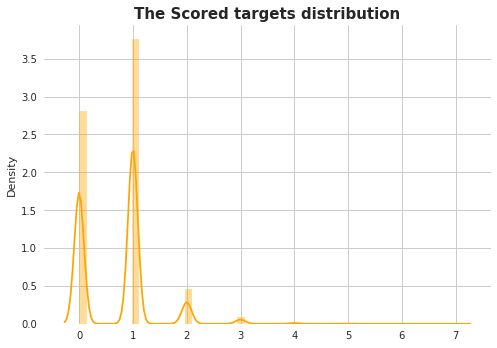

In [28]:
sns.distplot(train_targets_scored[target_cols_scored].sum(axis=1),color='orange')
plt.title("The Scored targets distribution", fontsize=15, weight='bold')
plt.show()

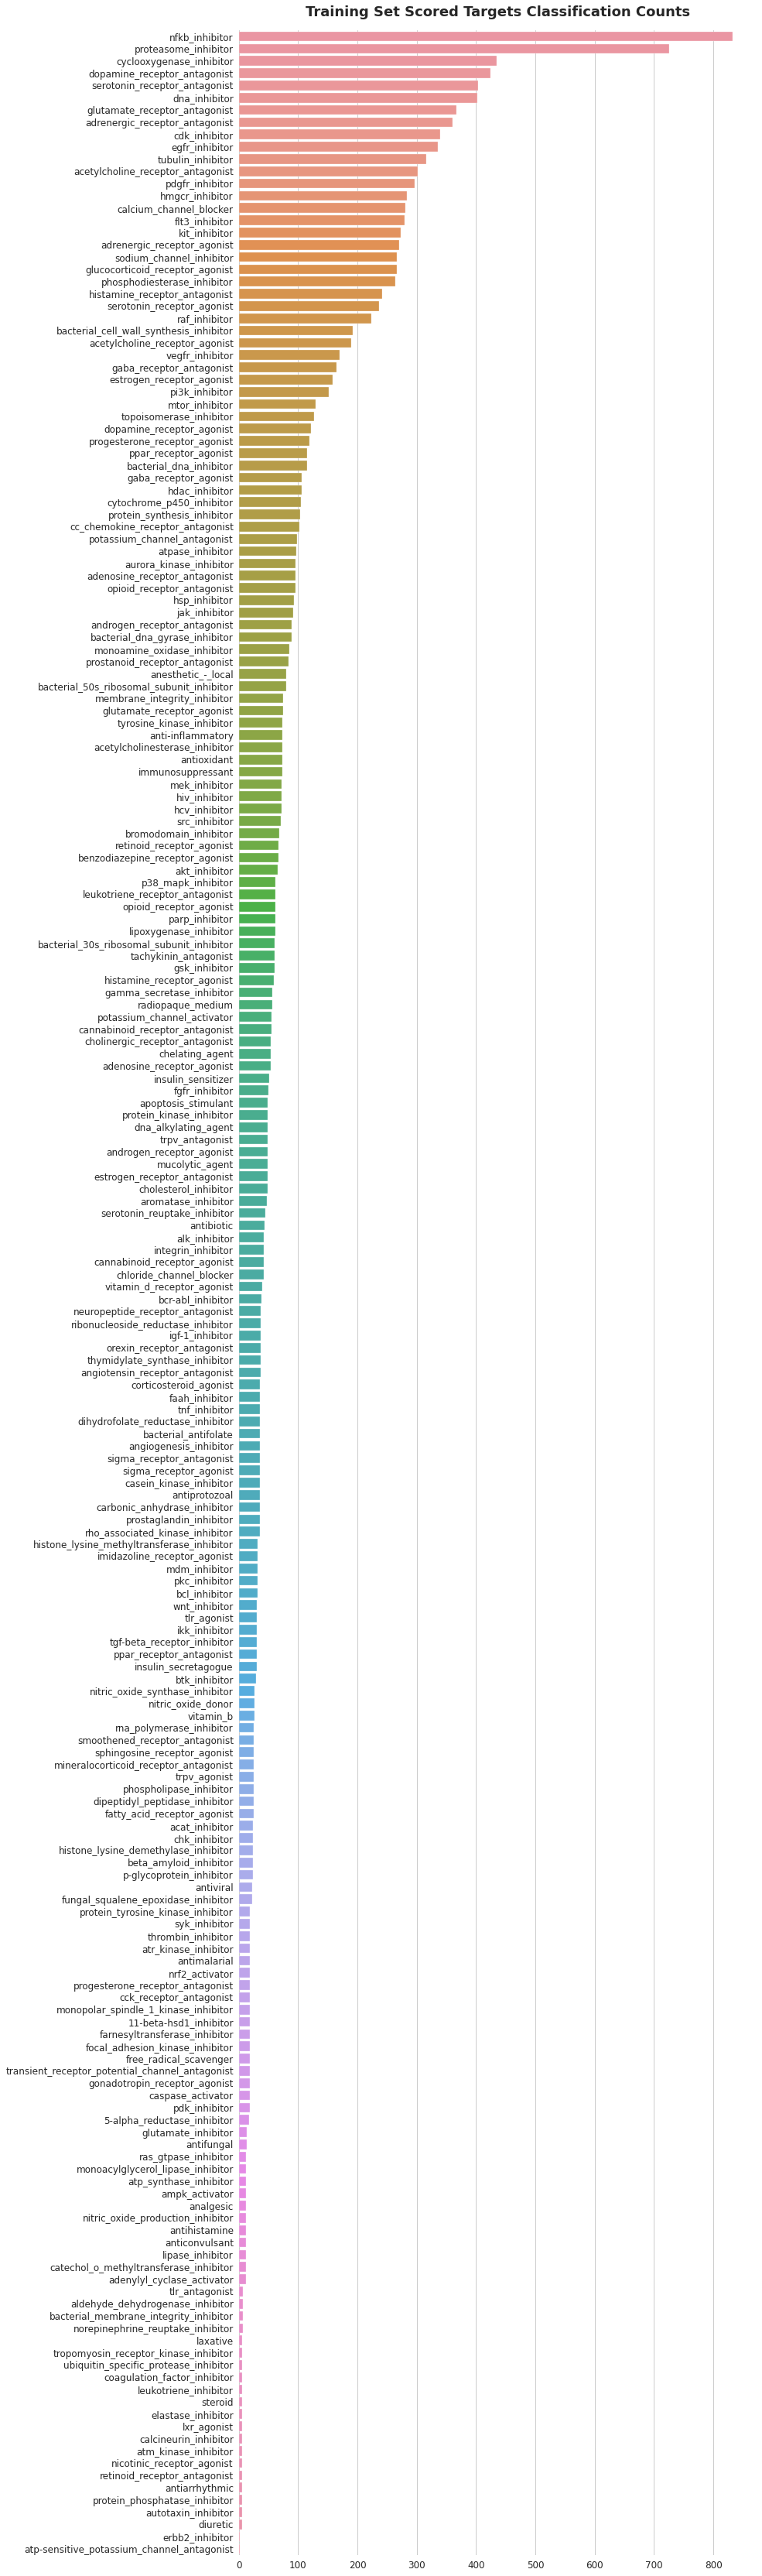

In [29]:
fig = plt.figure(figsize=(12, 60))

sns.barplot(x=train_targets_scored[target_cols_scored].sum(axis=0).sort_values(ascending=False).values,
            y=train_targets_scored[target_cols_scored].sum(axis=0).sort_values(ascending=False).index)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.xlabel('')
plt.ylabel('')
plt.title('Training Set Scored Targets Classification Counts', size=18, pad=18, weight='bold')
plt.show()

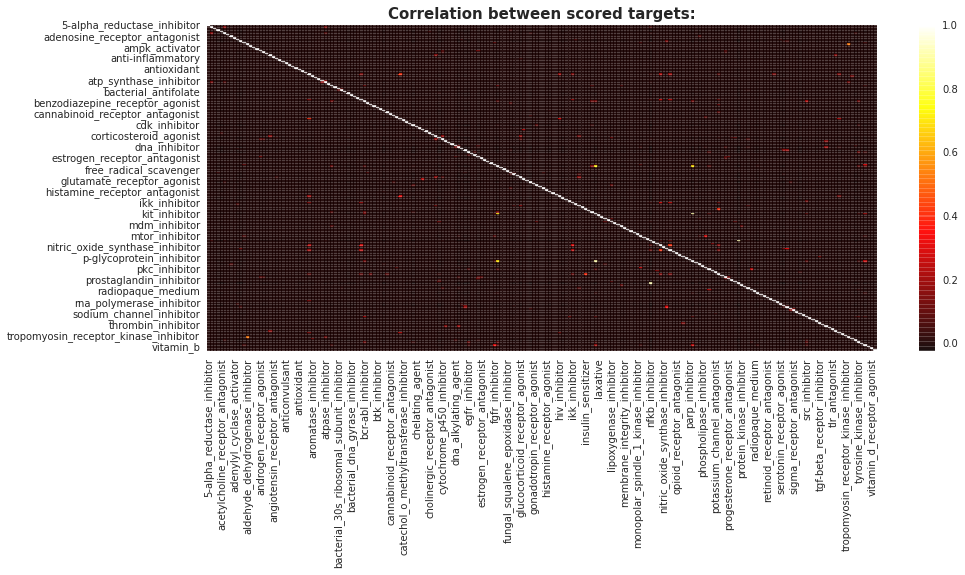

In [30]:
plt.figure(figsize=(15,6))
sns.heatmap(train_targets_scored[target_cols_scored].corr(),cmap='hot',alpha=0.75)
plt.title('Correlation between scored targets:', fontsize=15, weight='bold')
plt.show()

In [31]:
corrs(train_targets_scored[target_cols_scored],'Target 1', 'Target 2',rows=5)

2.0 Target 1 pairs have +0.9 correlation.


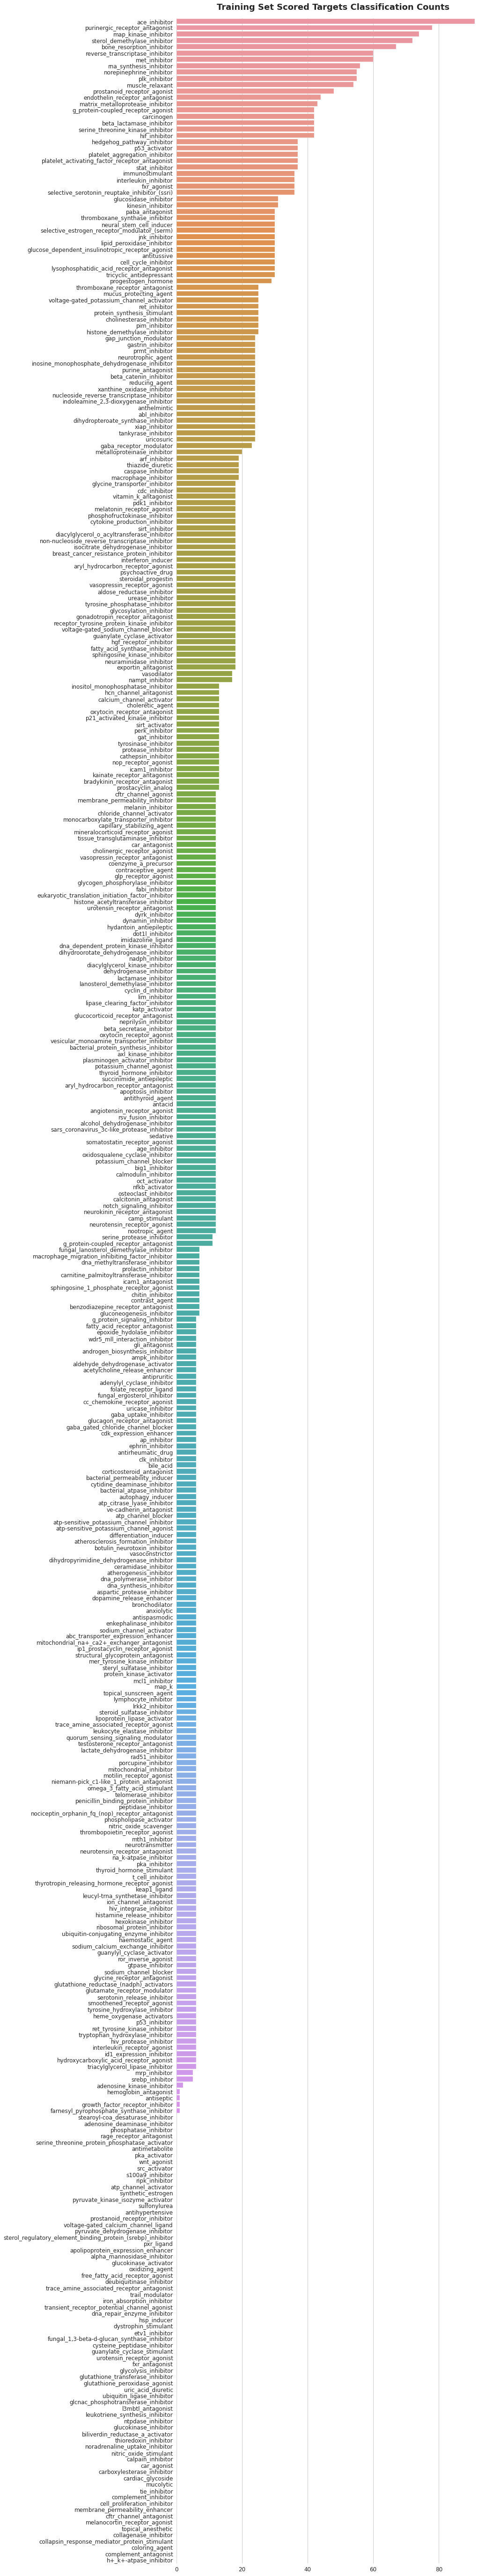

In [32]:
fig = plt.figure(figsize=(12, 100))

sns.barplot(x=train_targets_nonscored[target_cols_nonscored].sum(axis=0).sort_values(ascending=False).values,
            y=train_targets_nonscored[target_cols_nonscored].sum(axis=0).sort_values(ascending=False).index)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.xlabel('')
plt.ylabel('')
plt.title('Training Set Scored Targets Classification Counts', size=18, pad=18, weight='bold')
plt.show()

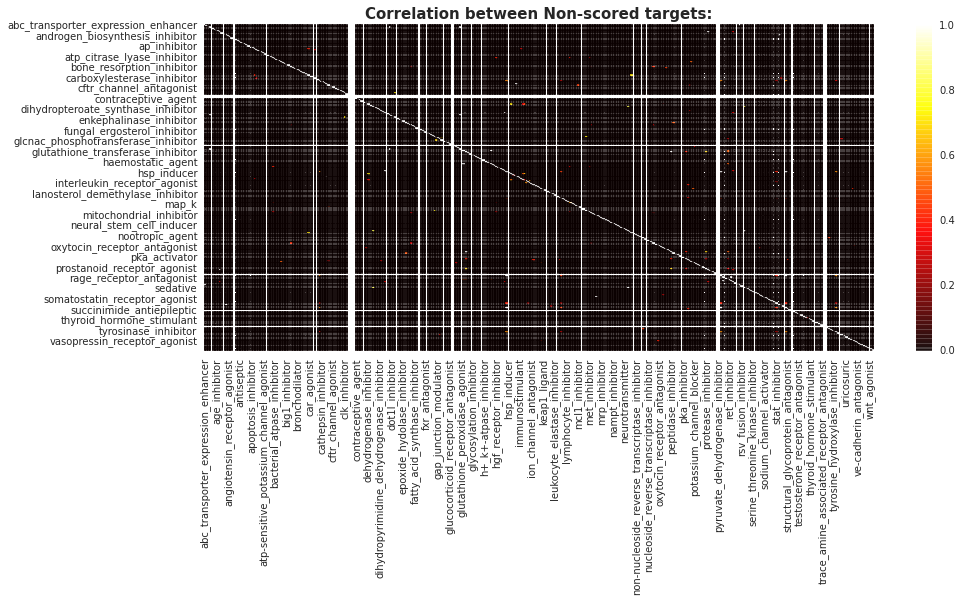

In [33]:
plt.figure(figsize=(15,6))
sns.heatmap(train_targets_nonscored[target_cols_nonscored].corr(),cmap='hot',alpha=0.75)
plt.title('Correlation between Non-scored targets:', fontsize=15, weight='bold')
plt.show()

In [34]:
corrs(train_targets_nonscored[target_cols_nonscored],'Target 1', 'Target 2',rows=8)

0.0 Target 1 pairs have +0.9 correlation.


In [35]:
all_targets=train_targets_scored.merge(train_targets_nonscored, on='sig_id',how='left')
corrs(all_targets[target_cols_nonscored+target_cols_scored],'Target 1', 'Target 2',rows=8)

2.0 Target 1 pairs have +0.9 correlation.


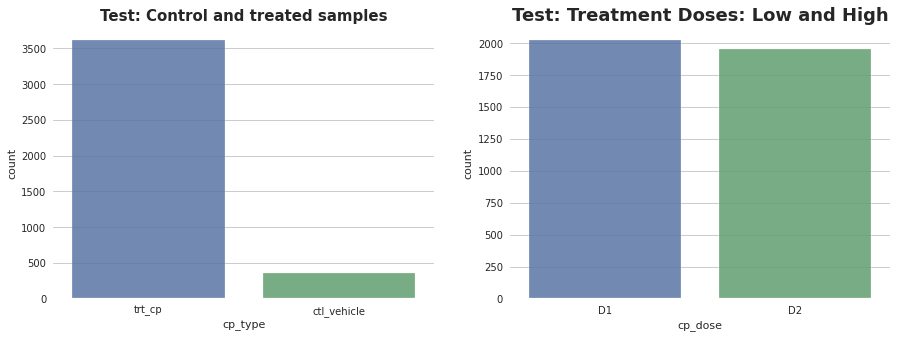

In [36]:
plt.style.use('seaborn')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
#1 rows 2 cols
#first row, first col
ax1 = plt.subplot2grid((1,2),(0,0))
sns.countplot(x='cp_type', data=test_features,alpha=0.85)
plt.title('Test: Control and treated samples', fontsize=15, weight='bold')
#first row sec col
ax1 = plt.subplot2grid((1,2),(0,1))
sns.countplot(x='cp_dose', data=test_features,  alpha=0.85)
plt.title('Test: Treatment Doses: Low and High',weight='bold', fontsize=18)
plt.show()

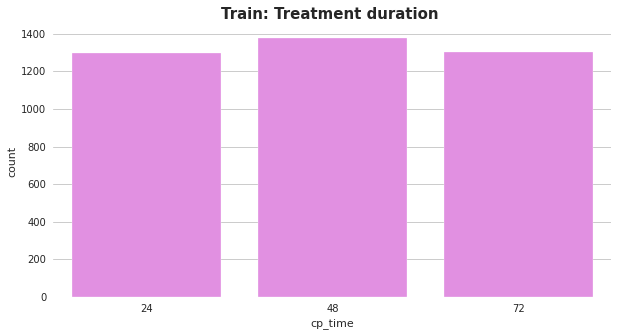

In [37]:
plt.figure(figsize=(10,5))
sns.countplot( test_features['cp_time'], color='violet')
plt.title("Train: Treatment duration ", fontsize=15, weight='bold')
plt.show()

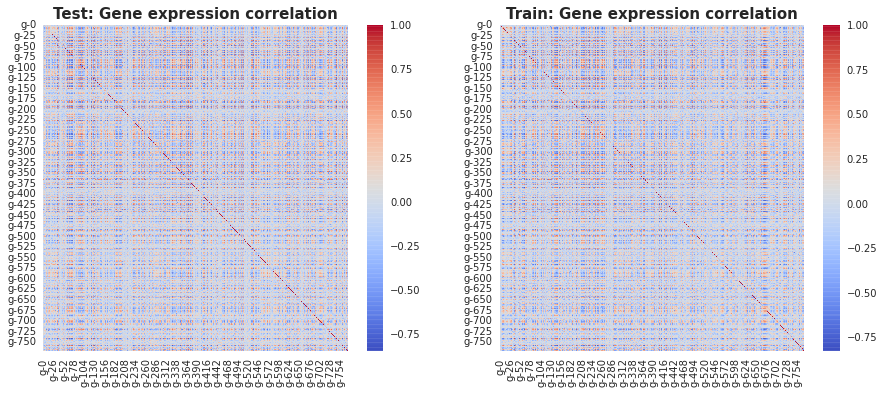

In [38]:
genes2 = treated(test_features)[GENES]
fig=plt.figure(figsize=(15,6))
#first row first col
ax1 = plt.subplot2grid((1,2),(0,0))
sns.heatmap(genes2.corr(),cmap='coolwarm',alpha=0.9)
plt.title('Test: Gene expression correlation', fontsize=15, weight='bold')

#first row sec col
ax1 = plt.subplot2grid((1,2),(0,1))
sns.heatmap(genes.corr(), cmap='coolwarm', alpha=0.9)
plt.title('Train: Gene expression correlation', fontsize=15, weight='bold')
plt.show()

In [39]:
corrs(genes2,'Gene 1', 'Gene 2',rows=8)

1.0 Gene 1 pairs have +0.9 correlation.


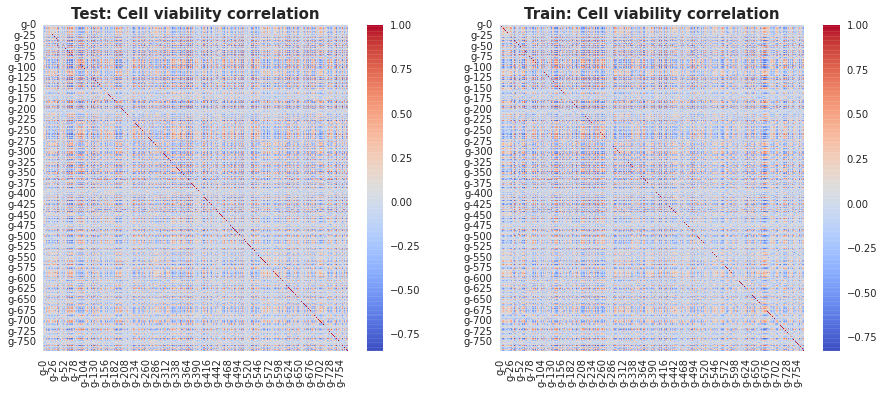

In [40]:
cells2 = treated(test_features)[CELLS]
fig=plt.figure(figsize=(15,6))
#first row first col
ax1 = plt.subplot2grid((1,2),(0,0))
sns.heatmap(genes2.corr(),cmap='coolwarm',alpha=0.9)
plt.title('Test: Cell viability correlation', fontsize=15, weight='bold')

#first row sec col
ax1 = plt.subplot2grid((1,2),(0,1))
sns.heatmap(genes.corr(), cmap='coolwarm', alpha=0.9)
plt.title('Train: Cell viability correlation', fontsize=15, weight='bold')
plt.show()

In [41]:
corrs(cells2,'Cells 1', 'Cells 2',rows=8)

455.0 Cells 1 pairs have +0.9 correlation.


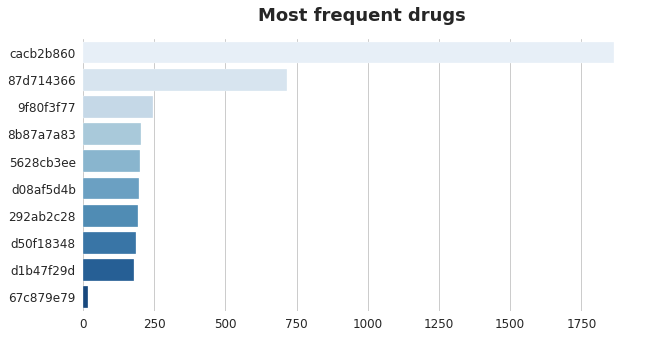

In [42]:
fig = plt.figure(figsize=(10,5))

sns.barplot(x=train_drug['drug_id'].value_counts().values[:10],
            y=train_drug['drug_id'].value_counts().index[:10],palette = "Blues")
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.xlabel('')
plt.ylabel('')
plt.title('Most frequent drugs', size=18, pad=18, weight='bold')
plt.show()

In [43]:
print('First observation:')
print(f"Number of rows of the Control vehicle is {len(train_features[train_features['cp_type']=='ctl_vehicle'])}")
print(f"Number of rows of the Drug cacb2b860 is {train_drug.drug_id.value_counts()[0]}")

First observation:
Number of rows of the Control vehicle is 1866
Number of rows of the Drug cacb2b860 is 1866


In [44]:
drug_count = train_drug[['drug_id']].value_counts().to_frame()
drug_count = drug_count.rename(columns={0:'drug_count'})
drug_count2=drug_count['drug_count'].value_counts().to_frame().reset_index()
drug_count2=drug_count2.rename(columns={'index': 'Samples per drug', 'drug_count':'Number of Drugs'})
drug_count2[:12]

Samples per drug  Number of Drugs
0                  6             2774
1                  7              196
2                  1              129
3                  5               66
4                 12               64
5                 13               25
6                 14                6
7                 11                4
8                  8                4
9                  2                3
10                 4                3
11                18                3

**Observations:**
* 2774 drugs out of 3700 drugs have 6 rows that correspond to 2 doses and 3 treatment times. 
* Only 64 drugs have 12 samples, I was expecting more drugs to be profiled twice.
* Only 3 drugs have 18 sample, the drugs were profiled 3 times.
***
### Conclusion of EDA:
* Train and Test Set share Quite same Distribution.
* Cell Features are highly correlation among themselves (can be used to create new features).
* Data is quite skewed , so some statistical features can be also be created.

The Cross Validation strategy i have used for submission is Multi-label stratified Kfold. 
* All Targets are highly correlative can be used for transfer learning.
* About 71 Non-scoredtargets don't have mechanism of action so can be dropped while pre-training.
***

In [1]:
print('this is my change to the code')

this is my change to the code
